### WLLS_II_estimator.ipynb
- Siep Dokter
- Emil Jousimaa
- Oleksandr Sosovskyy
- Mario Gabriele Carofano

> This file contains the implementation of an alternative WLLS estimator, named WLLS_II, as requested in the 4th task, used for estimate the Target Coordinates starting from the RSS information coming from the anchors.

> In addition, at the end of file, there are also plots showing the actual position of the target and the anchors, and the estimated position of the target obtained from the execution of the WLLS_II estimator.

In [28]:
# IMPORTS
import import_ipynb
import constants
import auxfunc
import pandas as pd
import numpy as np
import pprint
import math

In [29]:
def calculate_AII_matrix(anchor_coords, r):
	'''
	Calculates the 'AII' matrix of the system of equations [R2, (13)] which the WLLS_II method solves.
	This is the implementation of [R2, (14)].

	Parameters:
	anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.
	r (int) : An integer representing the index in 'anchor_coords' of the reference anchor.

	Returns:
	Returns a 2D numpy.ndarray which values
	are elements of the 'AII' matrix for the selected scenario.
	'''

	n_anchors = len(anchor_coords)
	AII = np.zeros((n_anchors, 2))

	for i in range(n_anchors):
		AII[i, 0] = anchor_coords[i][0] - anchor_coords[r][0]
		AII[i, 1] = anchor_coords[i][1] - anchor_coords[r][1]
	
	return 2 * AII

In [30]:
def calculate_bII_vector(anchor_coords, estimated_distances, r):
	'''
	Calculates the 'bII' vector of the system of equations [R2, eq. (13)] which the WLLS_II method solves.
	This is the implementation of [R2, eq. (14)].

	Parameters:
	anchor_coords (list) : A list containing one list for each anchor, e.g. the 2D-coordinates of each anchor.
	estimated_distances (list):
	A list containing one real number for each anchor,
	e.g. the distance estimation between each anchor and the target.
	r (int) : An integer representing the index in 'anchor_coords' of the reference anchor.

	Returns:
	Returns a 1D numpy.ndarray which values
	are elements of the 'bII' vector for the selected configuration.
	'''

	n_anchors = len(anchor_coords)
	first_term = math.pow(estimated_distances[r], 2)
	third_term = math.pow(anchor_coords[r][0], 2) + math.pow(anchor_coords[r][1], 2)
	bII = []

	for i in range(n_anchors):
		second_term = math.pow(estimated_distances[i], 2)
		fourth_term = third_term = math.pow(anchor_coords[i][0], 2) + math.pow(anchor_coords[i][1], 2)
		bII.append(first_term - second_term - third_term + fourth_term)
	
	return np.array(bII)


In [31]:
def calculate_CII_matrix(estimated_distances, r):
    '''
	Calculates, for the selected configuration, the 'CII' diagonal matrix.
	This is the implementation of [R2-13, sect. IV].

	Parameters:
	estimated_distances (list):
	A list containing one real number for each anchor,
	e.g. the distance estimation between each anchor and the target.
	r (int) : An integer representing the index in 'anchor_coords' of the reference anchor.

	Returns:
    Returns a 2D numpy.ndarray which values are elements
    of the 'CII' covariance matrix for the selected configuration.
	'''

    first_term = 4 * math.pow(estimated_distances[r], 2) * math.pow(constants.STANDARD_DEVIATION, 2)
    second_term = 2 * math.pow(constants.STANDARD_DEVIATION, 4)

    n_anchors = len(estimated_distances)
    CII = np.zeros((n_anchors, n_anchors))

    for i in range(n_anchors):
        for j in range(n_anchors):
            diag = 1 if i == j else 0
            third_term = 4 * math.pow(estimated_distances[i], 2) * math.pow(constants.STANDARD_DEVIATION, 2) + second_term
            CII[i, j] = first_term + second_term + diag * third_term
    
    return CII


In [32]:
def calculate_WLLS_II_output(AII, bII, CII):
	"""
	Calculates the Weighted Linear Least Squares (WLLS) position estimate.
	This is the implementation of [R2, eq. (20)].

	Parameters:
	AII (numpy.ndarray): Matrix AII.
	bII (numpy.ndarray): Vector bII.
	CII (numpy.ndarray): Weight matrix CII.

	Returns:
	Returns the WLLS_II position estimate.
	"""
	
	AII_transpose = np.transpose(AII)
	CII_inverse = np.linalg.inv(CII)
    
	mult = np.matmul(AII_transpose, CII_inverse)
    
	first_term = np.linalg.inv(np.matmul(mult, AII))
	second_term = np.matmul(mult, bII)
    
	return np.matmul(first_term, second_term)

In [33]:
def apply_WLLS_II_estimator(scenario_name):
	'''
	Applies the WLLS_II estimator, as shown in [R2].
	It is used for estimate the target's position from the anchors' position.

	Parameters:
	scenario_name (str): The name of the scenario to be examined.

	Returns:
	data (dict):
	It is a dictionary containing all the salient information retrieved
	from the reading of the dataset (Actual) and from the application of the WLLS_II estimator (Estimated),
	for all types of devices (Arduino, RPI) and for all technology (WiFi, BLT, Hybrid).
	'''
	
	dataset = auxfunc.define_dataset(scenario_name)

	for type in dataset[scenario_name]:

		dict = dataset[scenario_name][type]
		type_path = constants.DATASET_DIRECTORY + scenario_name + "/" + type + "/"

		for tech in dict:
			dataframes = []
			if tech != constants.HYBRID_TECHNOLOGY:
				for a in dict[tech]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + tech + "/" + a
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			else:
				# Concatenates the blt and wifi estimations
				for b in dict[constants.BLT_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.BLT_TECHNOLOGY + "/" + b
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))

				for w in dict[constants.WIFI_TECHNOLOGY]["Actual"]["Anchors' Name"]:
					anchor_path = type_path + constants.WIFI_TECHNOLOGY + "/" + w
					dataframes.append(pd.read_csv(
						anchor_path,
						sep=constants.CSV_FIELDS_SEPARATOR
					))
			
			dict[tech]["Actual"]["Dataframes"] = dataframes

		for tech in dict:
			dataframes = dict[tech]["Actual"]["Dataframes"]
			length = auxfunc.calculate_smallest_dataset(dataframes)
			burst_quantity = auxfunc.calculate_burst_quantity(length)
			n_anchors = len(dict[tech]["Actual"]["Anchors' Name"])

			# print(type, tech, length, burst_quantity, n_anchors, len(dataframes))

			dict[tech]["Actual"]["Distance Target - Anchor"] = []
			dict[tech]["Actual"]["Anchor Coordinates"] = []
			for a in range(n_anchors):
				dict[tech]["Actual"]["Distance Target - Anchor"].append(dataframes[a]["Distance Target - Anchor [m]"][0])
				dict[tech]["Actual"]["Target Coordinates"] = [eval(i) for i in dataframes[a]["Target Coordinates [m]"][0].split(", ")]
				dict[tech]["Actual"]["Anchor Coordinates"].append([eval(i) for i in dataframes[a]["Relative Coordinates [m]"][0].split(", ")])

			for c in range(burst_quantity):
				dict[tech]["Estimated"][c] = {}
				dict[tech]["Estimated"][c]["Average RSS"] = []
				dict[tech]["Estimated"][c]["Distance Target - Anchor"] = []
				
				for a in range(n_anchors):
					average_RSS = auxfunc.calculate_average_RSS(dataframes[a]["Rx Power [dBm]"].to_list(), c, length)
					estimated_distance = auxfunc.calculate_target_anchor_estimation(average_RSS)
					dict[tech]["Estimated"][c]["Average RSS"].append(average_RSS)
					dict[tech]["Estimated"][c]["Distance Target - Anchor"].append(estimated_distance)
				
				AII = calculate_AII_matrix(dict[tech]["Actual"]["Anchor Coordinates"], 0)
				bII = calculate_bII_vector(dict[tech]["Actual"]["Anchor Coordinates"], dict[tech]["Estimated"][c]["Distance Target - Anchor"], 0)
				CII = calculate_CII_matrix(dict[tech]["Estimated"][c]["Distance Target - Anchor"], 0)
				
				dict[tech]["Estimated"][c]["AII matrix"] = AII
				dict[tech]["Estimated"][c]["bII vector"] = bII
				dict[tech]["Estimated"][c]["CII matrix"] = CII
				dict[tech]["Estimated"][c]["Target Coordinates"] = calculate_WLLS_II_output(AII, bII, CII)[[0,1]]
			
			dataset[scenario_name][type][tech] = dict[tech]

	return dataset
	
# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array

In [34]:
data = {}
data.update(apply_WLLS_II_estimator("Scenario A"))
data.update(apply_WLLS_II_estimator("Scenario B"))
data.update(apply_WLLS_II_estimator("Scenario C"))

# np.set_printoptions(suppress=True)
# pprint.pprint(data)
# for configuration in data["Scenario A"]["RPI"]["RSS_BLT_Dataset"]["Estimated"].values():
#     pprint.pprint(configuration["Target Coordinates"])

In [35]:
for scenario in data:
    print("RMSE per", scenario)
    for type in data[scenario]:
        for tech in data[scenario][type]:
            print(type + "_" + tech + ":", auxfunc.calculate_rmse(data[scenario][type][tech]), "m")
    print()

RMSE per Scenario A
RPI_RSS_BLT_Dataset: 0.671 m
RPI_RSS_WiFi_Dataset: 0.151 m
RPI_RSS_Hybrid_Dataset: 0.187 m
Arduino_RSS_WiFi_Dataset_5dbm: 0.599 m
Arduino_RSS_WiFi_Dataset_0dbm: 0.458 m
Arduino_RSS_WiFi_Dataset_15dbm: 0.295 m
Arduino_RSS_WiFi_Dataset_10dbm: 0.822 m
Arduino_RSS_WiFi_Dataset_20dbm: 0.118 m

RMSE per Scenario B
RPI_RSS_BLT_Dataset: 6.025 m
RPI_RSS_WiFi_Dataset: 4.96 m
RPI_RSS_Hybrid_Dataset: 5.224 m

RMSE per Scenario C
RPI_RSS_BLT_Dataset: 0.912 m
RPI_RSS_WiFi_Dataset: 0.084 m
RPI_RSS_Hybrid_Dataset: 0.209 m



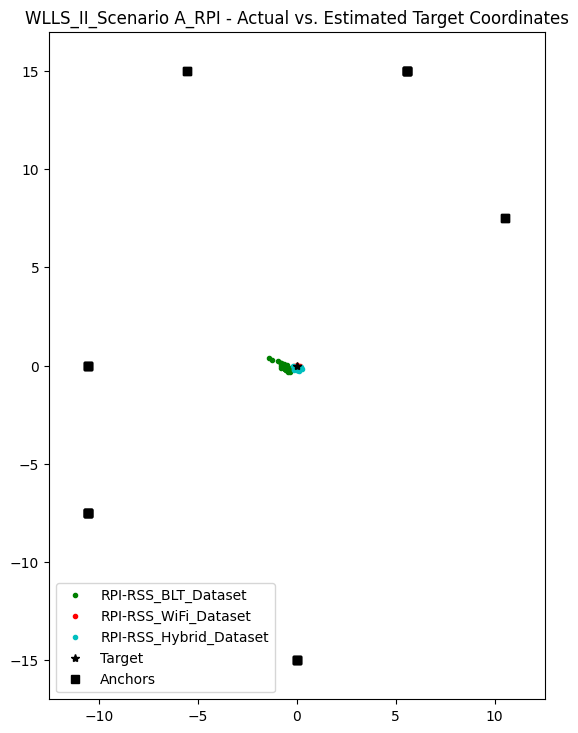

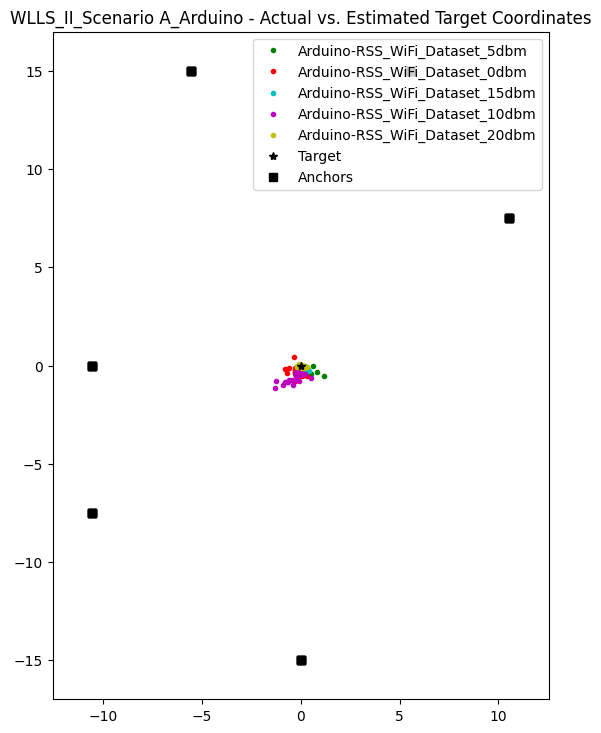

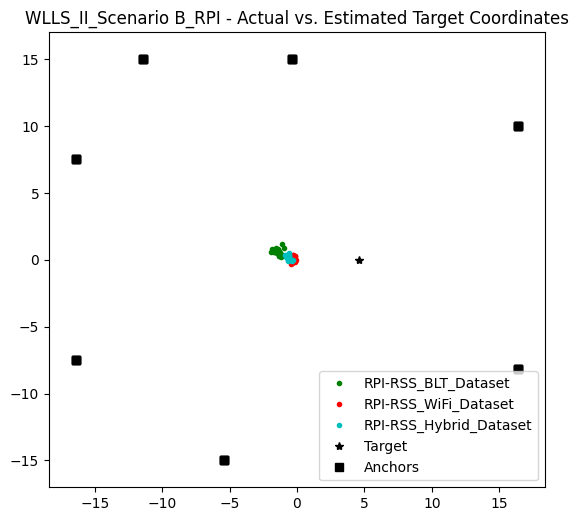

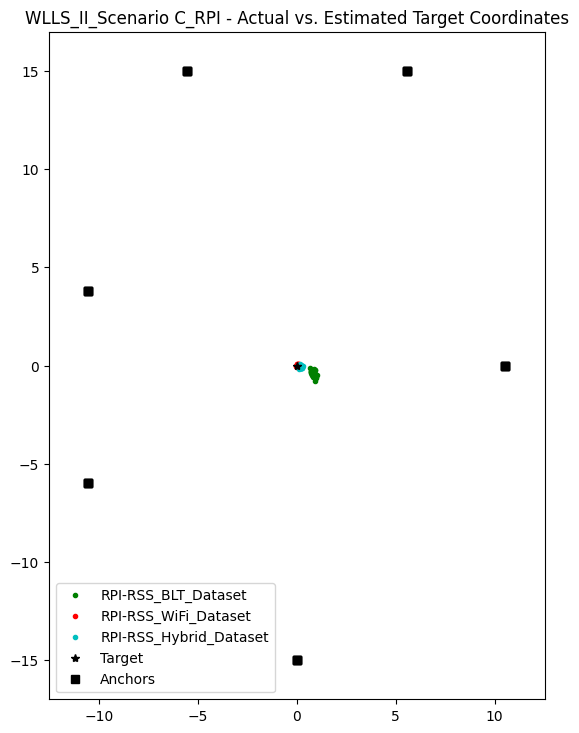

In [36]:
auxfunc.plot_data("WLLS_II", data)